# 4. Bayesian Networks

In [1]:
%run '0. Preamble.ipynb'

connect to this kernel with:
  jupyter console --existing 965732d8-9276-4cfd-b7d3-ae732b24f5cd


In [2]:
import lark

from thomas.core import BayesianNetwork
from thomas.core import examples
from thomas.core.reader import oobn

from IPython.display import display, HTML

Using thomas.core version: 2020-03-03 08:40
Using Pandas version: 1.0.1
Current working directory:
  /Users/melle/python_projects/thomas/thomas-core/notebooks


In [3]:
thomas_log = logging.getLogger('thomas')
thomas_log.setLevel(logging.DEBUG)

In [4]:
# Load the Student Network from the examples
Gs = examples.get_student_network()
Gs

<BayesianNetwork name='Student'>
  <Node RV='I' states=['i0', 'i1'] />
  <Node RV='S' states=['s0', 's1'] />
  <Node RV='D' states=['d0', 'd1'] />
  <Node RV='G' states=['g1', 'g2', 'g3'] />
  <Node RV='L' states=['l0', 'l1'] />
</BayesianNetwork>

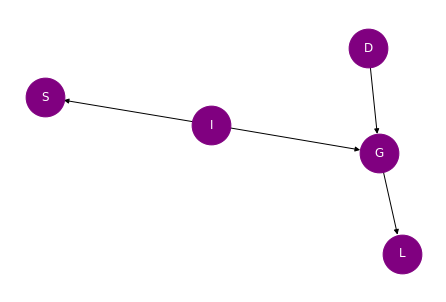

In [5]:
# Show the network and its relations
Gs.draw()

In [6]:
# Accessing individual Nodes/CPTs is easy
Gs['S'].cpt

S,s0,s1
I,,
i0,0.95,0.05
i1,0.20,0.80


In [7]:
# Querying the network is also simple. To compute the marginals over I, S and D:
Gs.compute_marginals(['I', 'S', 'D'])

{'I': factor(I)
 I
 i0    0.7
 i1    0.3
 dtype: float64,
 'S': factor(S)
 S
 s0    0.725
 s1    0.275
 dtype: float64,
 'D': factor(D)
 D
 d0    0.6
 d1    0.4
 dtype: float64}

In [8]:
# To compute the marginals over I, S and D given evidence I=i0:
Gs.compute_marginals(['I', 'S', 'D'], {'I':'i0'})

{'I': factor(I)
 I
 i0    1.0
 i1    0.0
 dtype: float64,
 'S': factor(S)
 S
 s0    0.95
 s1    0.05
 dtype: float64,
 'D': factor(D)
 D
 d0    0.6
 d1    0.4
 dtype: float64}

In [9]:
# Complex queries can be run simply by providing the query as string:
Gs.P('I=i0|S')

I,i0
S,
s0,0.917241
s1,0.127273


In [10]:
# This should be equal to Gs['S'] 
Gs.P('S|I')

S,s0,s1
I,,
i0,0.95,0.05
i1,0.20,0.80


In [11]:
# Alternatively, parameters can be specified separately through 
# `compute_posterior()`:
Gs.compute_posterior(qd=['I'], qv={}, ed=['S'], ev={})

I,i0,i1
S,,
s0,0.917241,0.082759
s1,0.127273,0.872727


In [12]:
# A CPT can be converted to a pandas.DataFrame by calling `unstack()` without
# parameters. Note that this only works if there are conditioning variables.
unstacked = Gs.P('I|S').unstack()
print(f'type(unstacked): {type(unstacked)}')
print()
display(unstacked)

type(unstacked): <class 'pandas.core.frame.DataFrame'>



I,i0,i1
S,,
s0,0.917241,0.082759
s1,0.127273,0.872727


In [13]:
# Nodes can be accessed by using the BN as a `dict`:
node = Gs['S']
node

DiscreteNetworkNode('S', name='S', states=['s0', 's1'])

In [14]:
# The Node-property 'states' will return a list of allowed states.
Gs['S'].states

['s0', 's1']

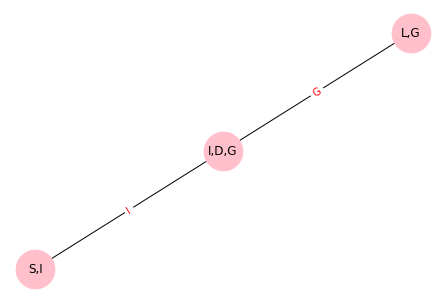

In [15]:
# The junction tree (jointree) can be inspected by calling `jt.draw()`:
Gs.jt.draw()